### LOADING LIBRARIES

In [30]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)

In [31]:
import cv2
import glob, os
import ast
import time
import dlib
import sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
from utils import *
from generator import *
from model import KeypointModel
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tensorflow import keras as k
from sklearn.model_selection import train_test_split

np.random.seed(0)
tf.random.set_random_seed(0)

### DATA LOADING

In [2]:
PATH = "./data"
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"
TRAIN_FOLDER = "train_images"
TEST_FOLDER = "test_images"

BATCH_SIZE=8
WEIGHT_FILENAME = "face_keypoint_mobile.h5"

def str_to_list(df):
    df.pts_x = df.pts_x.apply(lambda x: ast.literal_eval(x))
    df.pts_y = df.pts_y.apply(lambda x: ast.literal_eval(x))
    return df

In [3]:
train_df = pd.read_csv(os.path.join(PATH, TRAIN_CSV))
test_df = pd.read_csv(os.path.join(PATH, TEST_CSV))

In [4]:
train_df, test_df = str_to_list(train_df), str_to_list(test_df)

In [5]:
train_df['pts'] = train_df.apply(
    lambda x: combine_list(x.pts_x, x.pts_y), axis=1)
test_df['pts'] = test_df.apply(
    lambda x: combine_list(x.pts_x, x.pts_y), axis=1)

In [6]:
train_df.head()

filename  \
0     51--Dresses/51_Dresses_wearingdress_51_377.jpg   
1             19--Couple/19_Couple_Couple_19_340.jpg   
2  15--Stock_Market/15_Stock_Market_Stock_Market_...   
3       44--Aerobics/44_Aerobics_Aerobics_44_543.jpg   
4  5--Car_Accident/5_Car_Accident_Accident_5_938.jpg   

                                               pts_x  \
0  [0.0505, 0.063, 0.0695, 0.0656, 0.0585, 0.0563...   
1  [0.1775, 0.1798, 0.1822, 0.1849, 0.188, 0.1924...   
2  [0.056, 0.0568, 0.057, 0.0576, 0.0612, 0.0699,...   
3  [0.3232, 0.3259, 0.3287, 0.3316, 0.3348, 0.338...   
4  [0.2275, 0.2278, 0.2294, 0.2336, 0.2412, 0.251...   

                                               pts_y                  bbox  \
0  [0.3844, 0.4164, 0.45, 0.484, 0.5177, 0.552, 0...  [275, 277, 765, 957]   
1  [0.3507, 0.3919, 0.4332, 0.4744, 0.5155, 0.556...   [527, 65, 820, 348]   
2  [0.3054, 0.3534, 0.4014, 0.4494, 0.4972, 0.544...   [234, 93, 462, 363]   
3  [0.3974, 0.4192, 0.4411, 0.4629, 0.4847, 0.506...  [728, 523, 991, 766]   
4  [0.3705, 0.4056, 0.4407, 0.4755, 0.5098, 0.543...  [452, 190, 695, 416]   

     x    y  height  width   hw newfile  \
0  275  277     680    490  680   0.jpg   
1  527   65     283    293  293   1.jpg   
2  234   93     270    228  270   2.jpg   
3  728  523     243    263  263   3.jpg   
4  452  190     226    243  243   4.jpg   

                                                 pts  
0  [0.0505, 0.3844, 0.063, 0.4164, 0.0695, 0.45, ...  
1  [0.1775, 0.3507, 0.1798, 0.3919, 0.1822, 0.433...  
2  [0.056, 0.3054, 0.0568, 0.3534, 0.057, 0.4014,...  
3  [0.3232, 0.3974, 0.3259, 0.4192, 0.3287, 0.441...  
4  [0.2275, 0.3705, 0.2278, 0.4056, 0.2294, 0.440...

In [7]:
test_df.head()

filename  \
0         37--Soccer/37_Soccer_soccer_ball_37_45.jpg   
1  31--Waiter_Waitress/31_Waiter_Waitress_Waiter_...   
2             4--Dancing/4_Dancing_Dancing_4_355.jpg   
3  49--Greeting/49_Greeting_peoplegreeting_49_611...   
4  29--Students_Schoolkids/29_Students_Schoolkids...   

                                               pts_x  \
0  [0.0204, 0.0302, 0.0405, 0.0517, 0.0642, 0.078...   
1  [0.2287, 0.2328, 0.2375, 0.2433, 0.2502, 0.257...   
2  [0.0881, 0.0857, 0.0851, 0.0884, 0.0973, 0.111...   
3  [0.2312, 0.2347, 0.233, 0.226, 0.2183, 0.2143,...   
4  [0.0108, 0.0199, 0.0301, 0.0428, 0.0593, 0.080...   

                                               pts_y                  bbox  \
0  [0.2519, 0.2988, 0.3456, 0.3922, 0.4384, 0.484...  [178, 217, 364, 423]   
1  [0.3416, 0.377, 0.4123, 0.4475, 0.4825, 0.5174...   [513, 50, 761, 268]   
2  [0.4157, 0.4584, 0.5011, 0.5437, 0.5855, 0.625...   [91, 160, 213, 325]   
3  [0.3149, 0.3486, 0.3824, 0.4156, 0.4486, 0.482...  [738, 28, 1124, 396]   
4  [0.3641, 0.4107, 0.4571, 0.5028, 0.5473, 0.589...  [198, 142, 442, 426]   

     x    y  height  width   hw newfile  \
0  178  217     206    186  206   0.jpg   
1  513   50     218    248  248   1.jpg   
2   91  160     165    122  165   2.jpg   
3  738   28     368    386  386   3.jpg   
4  198  142     284    244  284   4.jpg   

                                                 pts  
0  [0.0204, 0.2519, 0.0302, 0.2988, 0.0405, 0.345...  
1  [0.2287, 0.3416, 0.2328, 0.377, 0.2375, 0.4123...  
2  [0.0881, 0.4157, 0.0857, 0.4584, 0.0851, 0.501...  
3  [0.2312, 0.3149, 0.2347, 0.3486, 0.233, 0.3824...  
4  [0.0108, 0.3641, 0.0199, 0.4107, 0.0301, 0.457...

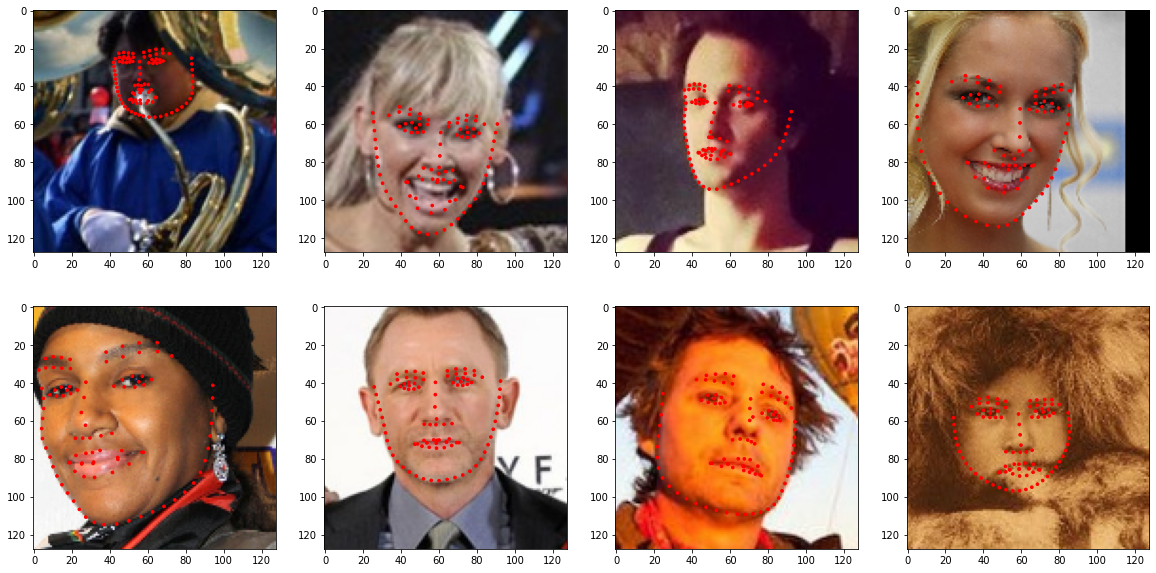

In [8]:
plot_keypoint_df(train_df,os.path.join(PATH, TRAIN_FOLDER))

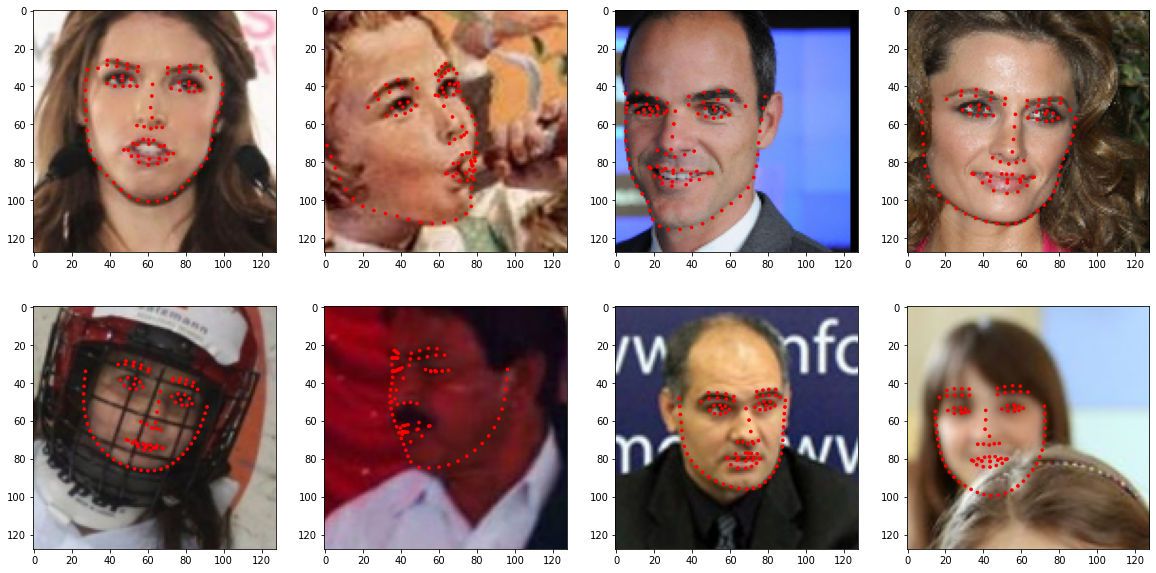

In [9]:
plot_keypoint_df(test_df,os.path.join(PATH, TEST_FOLDER))

In [10]:
# train_generator = DataGenerator(train_df,
#                                 BATCH_SIZE,
#                                 path=os.path.join(PATH, TRAIN_FOLDER),
#                                 is_valid=False)

test_generator = DataGenerator(test_df,
                               BATCH_SIZE,
                               path=os.path.join(PATH, TEST_FOLDER),
                               is_valid=True)

In [11]:
l = test_generator.__getitem__(2)
l[0].shape,l[1].shape

((8, 128, 128, 3), (8, 196))

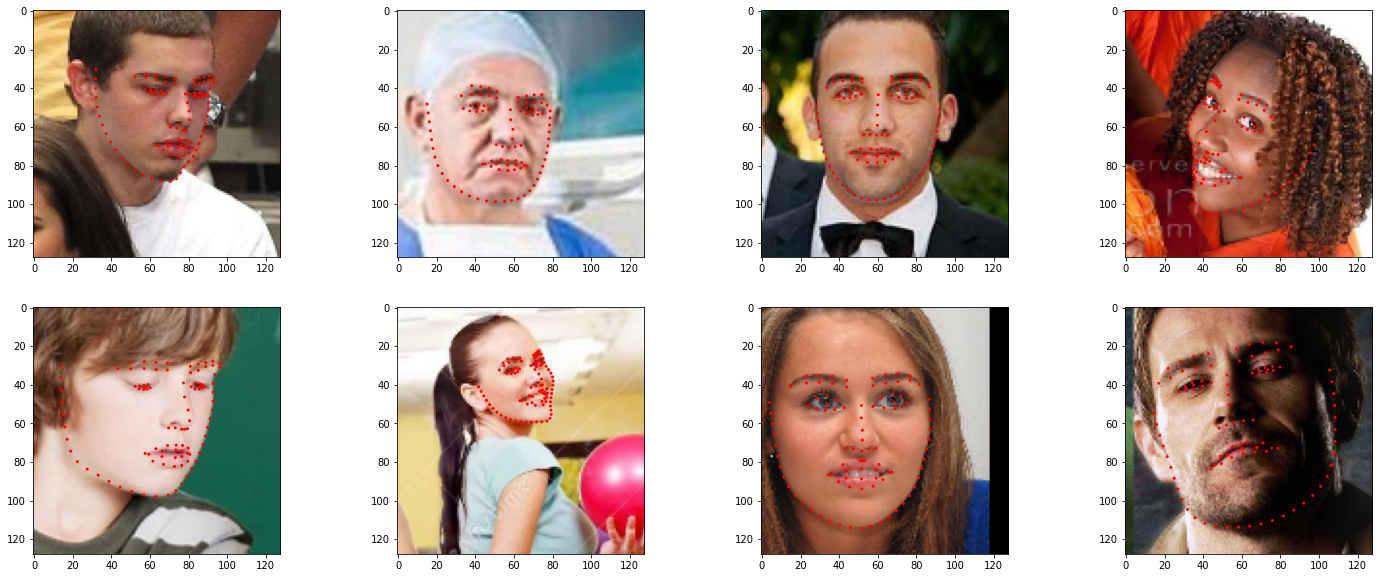

In [12]:
plot_keypoint_img(l[0],l[1])

### MODEL


In [13]:
model = KeypointModel()
print(model.summary(110))

/home/rj/.local/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0501 21:35:09.721496 140702684989248 deprecation.py:506] From /media/rj/Data/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0501 21:35:12.470794 140702684989248 deprecation_wrapper.py:119] From /home/rj/Documents/Projects/face_keypoint_detection/model.py:29: The name tf.keras.initializers.he_normal is deprecated. Please use tf.compat.v1.keras.initializers.he_normal instead.



Model: "facekeypoint"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
feature (InputLayer)                             [(None, 128, 128, 3)]                       0                
______________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                        (None, 129, 129, 3)                         0                
______________________________________________________________________________________________________________
conv1 (Conv2D)                                   (None, 64, 64, 16)                          432              
______________________________________________________________________________________________________________
conv1_bn (BatchNormalization)                    (None, 64, 64, 16)                       

### PREDICTIONS

In [14]:
model = k.models.load_model(os.path.join('./weights',WEIGHT_FILENAME))

W0501 21:35:12.517193 140702684989248 deprecation.py:506] From /media/rj/Data/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0501 21:35:12.517850 140702684989248 deprecation.py:506] From /media/rj/Data/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0501 21:35:12.519324 140702684989248 deprecation.py:506] From /media/rj/Data/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__i

In [38]:
images,labels = test_generator.__getitem__(2)
predictions = model.predict(images)


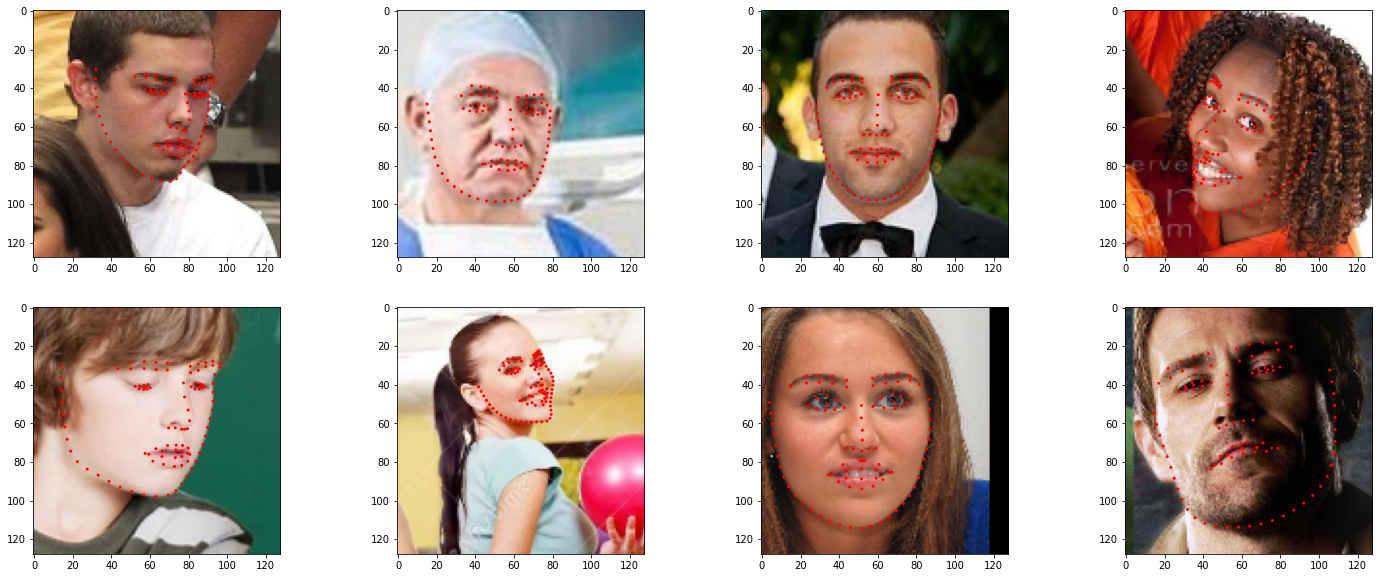

In [39]:
plot_keypoint_img(images,labels)

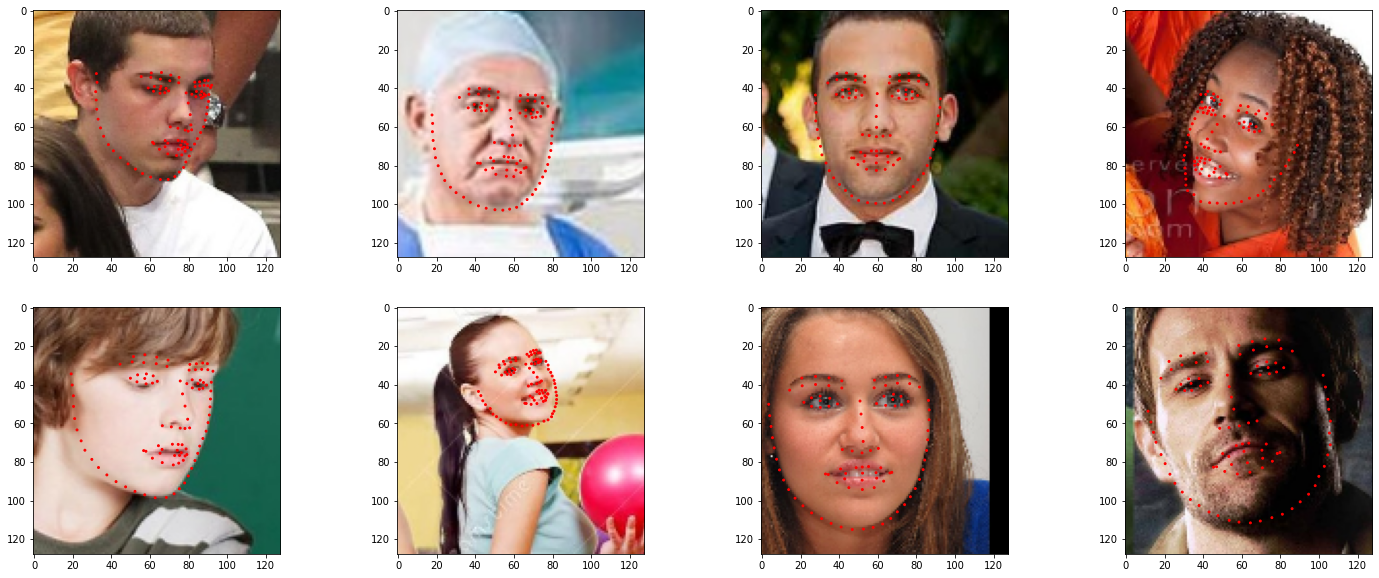

In [40]:
plot_keypoint_img(images,predictions)